# Set Up the Environment

### Install Dependencies

In [ ]:
# Install PyTorch and dependencies
%pip install torch torchvision

# Install Hugging Face Transformers for model loading
%pip install transformers

# Install dataset tools
%pip install datasets
# for image Processiing
%pip install opencv-python

### Importing Libraries and Drive Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from transformers import AutoModelForDepthEstimation
import time
import PIL
from PIL import Image
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

Mounted at /content/drive


# Define Needed Classes & Functions

Class for Depth Model

In [24]:
class DepthModel(nn.Module):
    def __init__(self, mod):
        super().__init__()
        self.model = mod
        self.eval()

    def forward(self, x):
        outputs = self.model(x)
        predicted_depth = outputs.predicted_depth
        return predicted_depth

Class for Dataset Loading & Preprocessing

In [4]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'JPG'))]
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image

Distillation Loss

In [ ]:
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2)**2 / float(2 * sigma**2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mul(_1D_window.t()).unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, window_size=11, size_average=True):
    channel = img1.size(1)
    window = create_window(window_size, channel)

    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)

    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)


class DepthDistillationLoss(nn.Module):
    def __init__(self, lambda_depth=1.0, lambda_si=1.0, lambda_grad=1.0, lambda_ssim=1.0):
        super().__init__()
        self.lambda_depth = lambda_depth # Weight for depth map MSE loss
        self.lambda_si = lambda_si # Weight for Scale-Invariant MSE loss
        self.lambda_grad = lambda_grad # Weight for Gradient loss
        self.lambda_ssim = lambda_ssim # Weight for SSIM loss

        self.mse_depth_loss = nn.MSELoss() # Mean Squared Error for depth maps
        self.l1_loss = nn.L1Loss() # L1 Loss for gradients

    def forward(self, student_outputs, teacher_outputs):
        student_depth = student_outputs
        teacher_depth = teacher_outputs

        # Ensure tensors have a batch dimension (unsqueeze if necessary)
        if student_depth.dim() == 3:
            student_depth = student_depth.unsqueeze(0)
        if teacher_depth.dim() == 3:
            teacher_depth = teacher_depth.unsqueeze(0)


        total_loss = torch.tensor(0.0, device=student_depth.device)

        # 1. MSE Depth Loss
        if self.lambda_depth > 0:
            loss_depth = self.mse_depth_loss(student_depth, teacher_depth)
            total_loss += self.lambda_depth * loss_depth

        # 2. Scale-Invariant MSE Loss
        if self.lambda_si > 0:
            diff = student_depth - teacher_depth
            loss_si = torch.mean(diff**2) - torch.mean(diff)**2
            total_loss += self.lambda_si * loss_si

        # 3. Gradient Loss (using L1 on gradients)
        if self.lambda_grad > 0:
            # Calculate gradients
            # Adjusted slicing for potential 4D tensors (Batch, Channels, Height, Width)
            # Assumes channels dimension is 1 for depth maps
            student_grad_x = torch.abs(student_depth[:, :, :, :-1] - student_depth[:, :, :, 1:])
            student_grad_y = torch.abs(student_depth[:, :, :-1, :] - student_depth[:, :, 1:, :])
            teacher_grad_x = torch.abs(teacher_depth[:, :, :, :-1] - teacher_depth[:, :, :, 1:])
            teacher_grad_y = torch.abs(teacher_depth[:, :, :-1, :] - teacher_depth[:, :, 1:, :])

            loss_grad = self.l1_loss(student_grad_x, teacher_grad_x) + self.l1_loss(student_grad_y, teacher_grad_y)
            total_loss += self.lambda_grad * loss_grad

        # 4. SSIM Loss
        if self.lambda_ssim > 0:
            # SSIM is typically calculated on normalized images, but for depth maps,
            # we can apply it directly or normalize based on min/max depth in the batch.
            # For simplicity, we'll apply it directly here.
            # You might want to experiment with normalizing depth maps before calculating SSIM.
            # Ensure tensors have a channel dimension for SSIM if it's missing
            ssim_student_depth = student_depth
            ssim_teacher_depth = teacher_depth

            if ssim_student_depth.dim() == 3: # Assuming Batch, Height, Width
                 ssim_student_depth = ssim_student_depth.unsqueeze(1) # Add channel dimension
            if ssim_teacher_depth.dim() == 3: # Assuming Batch, Height, Width
                 ssim_teacher_depth = ssim_teacher_depth.unsqueeze(1) # Add channel dimension

            # If the tensors are 4D but the channel dimension is > 1,
            # you might need to handle that based on how your depth maps are structured.
            # Assuming depth maps are single channel, we proceed if the channel dim is 1 or was just added.


            loss_ssim = 1 - ssim(ssim_student_depth, ssim_teacher_depth)
            total_loss += self.lambda_ssim * loss_ssim


        return total_loss

The Training Function

In [6]:
def train_knowledge_distillation(teacher, student, dataloader, criterion, optimizer, epochs, device):
    teacher.eval() # Teacher should always be in evaluation mode
    student.train() # Student in training mode

    print(f"Starting Knowledge Distillation Training on {device}...")
    models = []
    x = 0
    for epoch in range(epochs):
        running_loss = 0.0
        start_time = time.time()

        for batch_idx, inputs in enumerate(dataloader):
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # Forward pass with Teacher model (no_grad as teacher is fixed)
            with torch.no_grad():
                teacher_outputs = teacher(inputs) # Returns depth map and/or features

            # Forward pass with Student model
            student_outputs = student(inputs) # Returns depth map and/or features

            # Calculate distillation loss
            loss = criterion(student_outputs, teacher_outputs)

            # Backpropagation and Optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {running_loss / (batch_idx+1):.4f}")

        epoch_loss = running_loss / len(dataloader)
        end_time = time.time()
        print(f"Epoch {epoch+1} finished. Avg Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f}s")

        # Save student model checkpoint periodically
        if(epoch+1)%5 == 0:
          models.append(student)
          # torch.save(student.state_dict(), f"/content/drive/MyDrive/distill_any_depth_student_epoch_{epoch+1}.pth")
          # print(f"Student model saved to /content/drive/MyDrive/distill_any_depth_student_epoch_{epoch+1}.pth")

    print("Knowledge Distillation Training Finished!")
    return models

# Training Process

### Define Parameters & Models

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Load teacher model
teacher = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)

# Load student model
student = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf").to(device)

# Enable gradient checkpointing for teacher and student
teacher.gradient_checkpointing_enable()
student.gradient_checkpointing_enable()


teacher_model = DepthModel(teacher).to(device)
student_model = DepthModel(student).to(device)

# Initialize optimizer for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

# Training parameters
num_epochs = 15

# Distillation LOss
# Instantiate the custom loss function
distillation_criterion = DepthDistillationLoss(lambda_depth=0,  lambda_si=1.0, lambda_grad=1.0, lambda_ssim=1.0)

# transformations for input images (teacher and student will use the same)

input_size = (384, 384)

transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

# Specify the path to your unlabeled data in Google Drive
unlabeled_data_path = '/content/drive/MyDrive/images/'

# Create dataset and data loader
unlabeled_dataset = UnlabeledImageDataset(root_dir=unlabeled_data_path, transform=transform)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=4, shuffle=True, num_workers=2)



Using device: cuda
Found 48 images in /content/drive/MyDrive/images/


Befor Training

In [27]:
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = transform(Image.fromarray(image)).unsqueeze(0).to("cuda")

student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_depth_before = student_model(input_tensor)
    student_depth_before_training = student_depth_before.squeeze().cpu().numpy()


### Run the Training

In [34]:
    # Run the training
mods = train_knowledge_distillation(
    teacher=teacher_model,
    student=student_model,
    dataloader=unlabeled_dataloader,
    criterion=distillation_criterion,
    optimizer=student_optimizer,
    epochs=num_epochs,
    device=device
)

print("Training complete. Student model saved at specified checkpoints.")


Starting Knowledge Distillation Training on cuda...
Epoch 1 finished. Avg Loss: 12755.8500, Time: 13.16s
Epoch 2 finished. Avg Loss: 12272.6414, Time: 13.19s
Epoch 3 finished. Avg Loss: 10238.5172, Time: 13.54s
Epoch 4 finished. Avg Loss: 10144.8445, Time: 13.66s
Epoch 5 finished. Avg Loss: 8524.6782, Time: 13.92s
Epoch 6 finished. Avg Loss: 8482.9177, Time: 14.03s
Epoch 7 finished. Avg Loss: 8877.9611, Time: 14.02s
Epoch 8 finished. Avg Loss: 7842.9462, Time: 14.19s
Epoch 9 finished. Avg Loss: 7166.4006, Time: 14.35s
Epoch 10 finished. Avg Loss: 7022.6975, Time: 14.68s
Epoch 11 finished. Avg Loss: 7290.7402, Time: 14.54s
Epoch 12 finished. Avg Loss: 7133.9375, Time: 14.64s
Epoch 13 finished. Avg Loss: 7419.1586, Time: 14.64s
Epoch 14 finished. Avg Loss: 6964.6496, Time: 14.59s
Epoch 15 finished. Avg Loss: 6566.4578, Time: 14.51s
Knowledge Distillation Training Finished!
Training complete. Student model saved at specified checkpoints.


# Evaluation

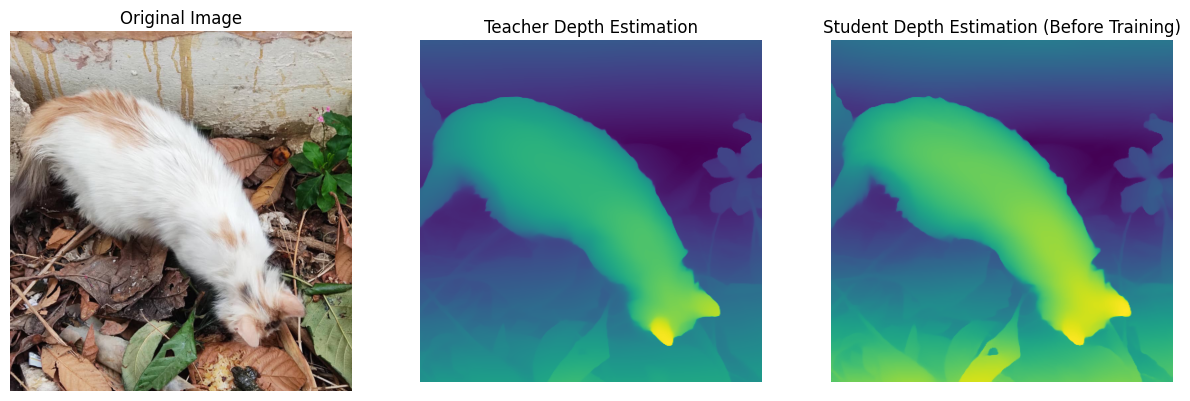

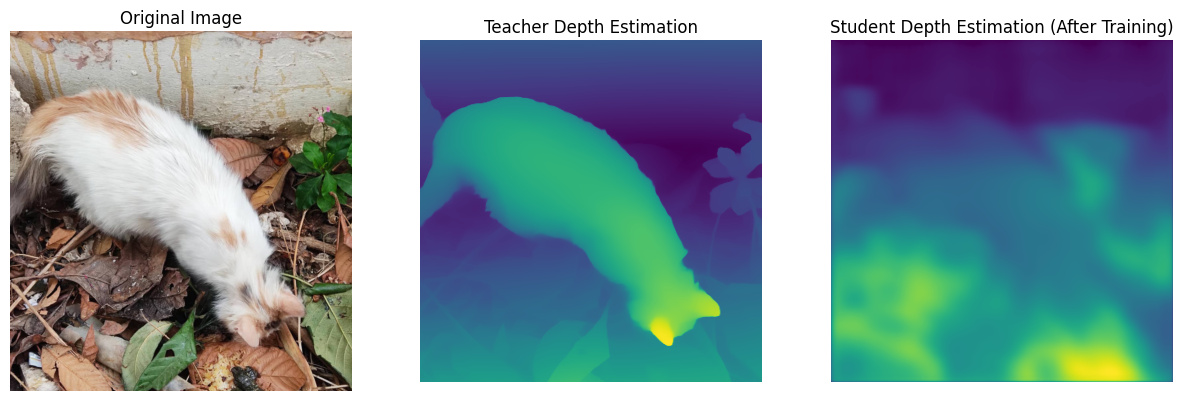

In [36]:
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = transform(Image.fromarray(image)).unsqueeze(0).to("cuda")

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_output_after = student_model(input_tensor)
    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()